In [1]:
from rvmep import anatomicalDirections, computeStrain, meshReconstruction, tools, deformMesh, edgeStructures, rotationOperations, propagateDeformation
import os, pyvista, numpy as np, collections, importlib,pathlib, tqdm, vtk, gdist
import scipy
import sklearn, sklearn.decomposition
import matplotlib.pyplot as plt
importlib.reload(meshReconstruction)

/home/gbernardino/miniconda3/lib/python3.9/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


<module 'rvmep.meshReconstruction' from '/home/gbernardino/rvmep/rvmep/meshReconstruction.py'>

In [2]:
def procrustes(Y, nIts = 20, partial = True):
    if len(Y.shape) == 3:
        Y = Y.reshape((len(Y), -1))
    #Registers every element to the mean, iteratively until a fix point
    Y_registered = np.copy(Y)
    n = Y_registered.shape[0]
    Y_old = np.zeros(Y.shape[1])
    scales = np.ones(len(Y))
    Rs = np.zeros((len(Y), 3, 3))
    displacement = np.zeros((len(Y), 3))
    for i in range(nIts):
        Y_mean = Y[0] if (i == 0) else np.mean(Y_registered, axis = 0)
        if np.linalg.norm(Y_old - Y_mean)/np.linalg.norm(Y_mean) < 1e-6:
            break
        else:
            Y_old = Y_mean
        
        Y_mean_3d = Y_mean.reshape((-1, 3))
        Y_mean_3d = Y_mean_3d - np.mean(Y_mean_3d, axis = 0)
        #if i == 0 and not partial:
        #    Y_mean_3d /= np.linalg.norm(Y_mean_3d)
        for i in range(n):
            y_3D = Y_registered[i].reshape((-1, 3))
            y_3D = y_3D - np.mean(y_3D, axis = 0)
            #A, y_3D_reg, _ = trimesh.registration.procrustes(y_3D, Y_mean_3d, scale =  not partial)
            if not partial:
                y_3D_reg,_, _ = scipy.spatial.procrustes(y_3D, Y_mean_3d)
            else:
                Rs[i], _ = scipy.linalg.orthogonal_procrustes(y_3D, Y_mean_3d)
                y_3D_reg= y_3D @ Rs[i]
            Y_registered[i] = y_3D_reg.flatten()
            scales[i] *= np.linalg.norm(y_3D_reg) / np.linalg.norm(y_3D)
    return Y_registered, Rs, scales
    
def computeStrainAnatomic(ref, moving):
    apexId, pointsTricuspid, pointsPulmonary = tools.getTomtecApexValvePointsRV()
    vLongitudinal, vCirc = anatomicalDirections.computeAnatomicalDirectionsHeatEquation(ref, apexId, valvePoints, True)
    S = computeStrain.computeStrainTensorGreen(ref, moving)
    return computeStrain.computeStrainCoefficientAlongDirection(S, vLongitudinal), computeStrain.computeStrainCoefficientAlongDirection(S, vCirc)


In [3]:
apexId, pointsTricuspid, pointsPulmonary = tools.getTomtecApexValvePointsRV()
valvePoints = np.concatenate([pointsTricuspid, pointsPulmonary])

In [4]:
meshes = collections.defaultdict(dict)
for p in pathlib.Path('Data').iterdir():
    if p.suffix == (".vtk"):
        n = p.stem.split('_')
        pId = '_'.join(n[:-1])
        frame = int(n[-1])
        meshes[pId][frame] = pyvista.PolyData(p)
meshes = {k : [v[t] for t,_ in enumerate(v)] for k, v in meshes.items()}


In [5]:
sampleMesh = meshes['ICCgrad4_VD'][0]

In [6]:
# Search for the patient with more longitudinal and more circumferential deformation
N = len(meshes)
gls, glc =  [], []
es, ed = [],[]
S_anatomic, dihedralAngles_es, dihedralAngles_ed = [], [], []
names =[]
for i, (k, m) in tqdm.tqdm(enumerate(meshes.items())):
    if i ==0:
        edges = edgeStructures.getEdges(m[0])

    if 'cam'  in k:
        continue
    ed.append(m[0])
    es_idx = np.argmin([mm.volume for mm in m])
    es.append(m[es_idx])

    apexId, pointsTricuspid, pointsPulmonary = tools.getTomtecApexValvePointsRV()
    vLongitudinal, vCirc = anatomicalDirections.computeAnatomicalDirectionsHeatEquation(ed[-1], apexId, valvePoints, True)
    systemOfCoordinates = np.stack([vLongitudinal, vCirc],axis = 1)

    S =  computeStrain.computeDeformationTensor(ed[-1], es[-1])
    S_anatomic.append(np.einsum('nij,njk,nhk-> nih', systemOfCoordinates,  S , systemOfCoordinates))
    dihedralAngles_es.append(meshReconstruction.computeDihedralAngles(es[-1].points, es[-1].cell_normals, edges))
    dihedralAngles_ed.append(meshReconstruction.computeDihedralAngles(ed[-1].points, ed[-1].cell_normals, edges))

    G = (np.einsum('nij,nkj->nik', S, S) - np.eye(3))/2

    l = computeStrain.computeStrainCoefficientAlongDirection(G, vLongitudinal)
    c= computeStrain.computeStrainCoefficientAlongDirection(G, vCirc)

    gls.append(np.mean(l))
    glc.append(np.mean(c))
    names.append(k)


0it [00:00, ?it/s]/home/gbernardino/miniconda3/lib/python3.9/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:144: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',
/home/gbernardino/rvmep/rvmep/anatomicalDirections.py:64: RuntimeWarning: invalid value encountered in divide
  vLongitudinal = vLongitudinal / np.linalg.norm(vLongitudinal, axis = 1).reshape((-1, 1))
124it [00:22,  5.47it/s]


In [7]:
Y_ED, Rs, _ = procrustes(np.array([y.points.flatten() for y in ed]))
for i, r in enumerate(Rs):
    m = np.mean(ed[i].points, axis = 0)
    ed[i].points = ed[i].points @ r -m
    es[i].points = es[i].points @ r -m

# Search for the patient with more longitudinal and more circumferential deformation
N = len(meshes)
gls, glc,es, ed, names, strain = [0] * N, [0] * N, [0] * N,[0] * N, [0] * N
for i, (k, m) in tqdm.tqdm(enumerate(meshes.items())):
    ed[i] = m[0]
    es_idx = np.argmin([mm.volume for mm in m])
    es[i] = m[es_idx]
    l, c = .computeStrainAnatomic(ed[i], es[i])
    gls[i],glc[i], names[i] = np.mean(l), np.mean(c), k

In [8]:
tgt_id, ref_id = np.argmin(gls), np.argmin(glc)
mesh_ED = ed[tgt_id]
mesh_ES = es[tgt_id]
mesh_ED.save('Meshes/tgt_ED.vtk')
mesh_ES.save('Meshes/tgt_ES.vtk')
mesh_ED = ed[ref_id]
mesh_ES = es[ref_id]
mesh_ED.save('Meshes/ref_ED.vtk')
mesh_ES.save('Meshes/ref_ES.vtk')


In [9]:
#Linear propagation
pyvista.PolyData(ed[tgt_id].points + (es[ref_id].points - ed[ref_id].points), faces = es[ref_id].faces).save('Output/exp1_direct.vtk')


# Synthetic deformation, reduced in the apex
apexId, pointsTricuspid, pointsPulmonary = tools.getTomtecApexValvePointsRV()
mesh_ED = ed[tgt_id]
mesh_ES = es[tgt_id]
edges = edgeStructures.getEdges(mesh_ED)
dihedrals_ED = meshReconstruction.computeDihedralAngles(mesh_ED.points, mesh_ED.cell_normals, edges)
dihedrals_ES = meshReconstruction.computeDihedralAngles(mesh_ES.points, mesh_ES.cell_normals, edges)
delta_dihedrals = dihedrals_ES - dihedrals_ED

vLongitudinal, vCirc = anatomicalDirections.computeAnatomicalDirectionsHeatEquation(mesh_ED, apexId, valvePoints, True)
systemOfCoordinatesTarget= np.stack([vLongitudinal, vCirc],axis = 1)

E = computeStrain.computeDeformationTensor(mesh_ED, mesh_ES)
E_anatomic = np.einsum('nij,njk,nhk-> nih', systemOfCoordinatesTarget,  E, systemOfCoordinatesTarget)
for i, e in enumerate(E_anatomic):
    if np.any(np.isnan(e)):
        E_anatomic[i] = np.eye(2)
pulmonaryValvePoint = 63
triangles = mesh_ED.faces.reshape((-1, 4))[:, 1:]
distance = gdist.compute_gdist(mesh_ED.points, triangles.astype(np.int32), np.array([pulmonaryValvePoint] ,dtype = np.int32 ))
distance_faces = np.mean(distance[triangles], axis = 1)

d = np.exp(-distance_faces**2/50**2)
k = .95
d = d > .5
d = (1-d)*k + (1-k)
d = d.reshape((-1,1,1))
d_edges = [(d[e.edge[0],0,0] + d[e.edge[1],0,0])/2 for e in edges]
E_anatomic_2 = d * (E_anatomic - np.eye(2)) + np.eye(2)
# Do the changes



coordinatesAnatomic = np.einsum('nij, nkj->nik', mesh_ED.points[triangles], systemOfCoordinatesTarget)
coordinatesAnatomic_transformed =np.einsum('nij, nkj->nki', E_anatomic_2, coordinatesAnatomic)
triangleCoordinates3D = propagateDeformation.getCoordinatesTriangle(mesh_ED, coordinatesAnatomic_transformed)
r = deformMesh.deformMeshOptimisation(mesh_ED, triangleCoordinates3D, dihedrals_ED + d_edges*delta_dihedrals)
r += (ed[tgt_id].points[apexId] -r[apexId])


/home/gbernardino/miniconda3/lib/python3.9/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:144: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',
/home/gbernardino/rvmep/rvmep/anatomicalDirections.py:64: RuntimeWarning: invalid value encountered in divide
  vLongitudinal = vLongitudinal / np.linalg.norm(vLongitudinal, axis = 1).reshape((-1, 1))


In [10]:
synthetic_es = pyvista.PolyData(r, faces = mesh_ED.faces)
sL, sC = computeStrainAnatomic( ed[tgt_id], synthetic_es)
sLReal, sCReal = computeStrainAnatomic( ed[tgt_id], es[tgt_id])

synthetic_es.cell_data['sL'] = sL
synthetic_es.cell_data['sC'] = sC
synthetic_es.cell_data['d'] = d.flatten()

synthetic_es.save('Output/synthetic_deformation.vtk')
print('gls target = ',  np.mean(sL))
print('glc target= ', np.mean(sC))

print('gls target = ',  np.mean(sLReal*d))
print('glc target= ', np.mean(sCReal*d))



es[tgt_id].cell_data['sL'] = sLReal
es[tgt_id].cell_data['sC'] = sCReal
es[tgt_id].cell_data['d'] = d.flatten()

es[tgt_id].save('Output/synthetic_deformation_es.vtk')


gls target =  -0.1738775995919953
glc target=  -0.13531888102704062
gls target =  -0.14980382779682608
glc target=  -0.10638579737918266


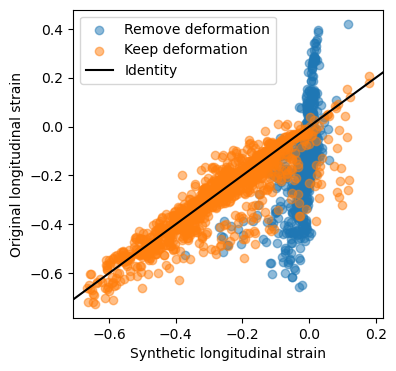

In [11]:
d0 = d.flatten() < .5
d1 = d.flatten() == 1.

plt.figure(figsize =(4,4))
plt.scatter(sL[d0], sLReal[d0], label = 'Remove deformation', alpha = .5)
plt.scatter(sL[d1], sLReal[d1], label = 'Keep deformation', alpha = .5 )
xmin,xmax = plt.xlim()
ymin, ymax = plt.ylim()
plt.plot([xmin,xmax], [xmin,xmax], c = 'k', label = 'Identity')
plt.xlim(xmin, xmax)
plt.legend()
plt.xlabel('Synthetic longitudinal strain')
plt.ylabel('Original longitudinal strain')
plt.savefig('Output/fig.png')

In [12]:
es_estimated_linear, _, _ = propagateDeformation.translateDeformation(ed[tgt_id], ed[ref_id], es[ref_id], linear = True)
pGenerated = pyvista.PolyData(es_estimated_linear, ed[tgt_id].faces)

srefL, srefC = computeStrainAnatomic( ed[tgt_id], es[tgt_id])
stargetL, stargetC = computeStrainAnatomic( ed[ref_id], es[ref_id])
scomputedL, scomputedC = computeStrainAnatomic( ed[tgt_id], pGenerated)



In [13]:
tgt_id, ref_id = np.argmin(gls), np.argmin(glc)
apexId, pointsTricuspid, pointsPulmonary = tools.getTomtecApexValvePointsRV()
vLongitudinal, vCirc = anatomicalDirections.computeAnatomicalDirectionsHeatEquation(ed[ref_id], apexId, valvePoints, True)
ed[ref_id].cell_data['l'] = vLongitudinal
ed[ref_id].cell_data['c'] = vCirc
vLongitudinal, vCirc = anatomicalDirections.computeAnatomicalDirectionsHeatEquation(ed[tgt_id], apexId, valvePoints, True)
ed[tgt_id].cell_data['l'] = vLongitudinal
ed[tgt_id].cell_data['c'] = vCirc


es_estimated = propagateDeformation.translateDeformation(ed[tgt_id], ed[ref_id], es[ref_id])
es_estimated += (ed[tgt_id].points[apexId] - es_estimated[apexId])
pGenerated = pyvista.PolyData(es_estimated, ed[tgt_id].faces)

stargetL, stargetC= computeStrainAnatomic( ed[tgt_id], es[tgt_id])
srefL, srefC = computeStrainAnatomic( ed[ref_id], es[ref_id])
scomputedL, scomputedC = computeStrainAnatomic( ed[tgt_id], pGenerated)

pGenerated.cell_data['error_l'] = stargetL- scomputedL
pGenerated.cell_data['error_c'] = stargetC- scomputedC
es[tgt_id].cell_data['l'] = stargetL
es[tgt_id].cell_data['c'] = stargetC

pGenerated.save('Output/exp1_es_tgt_estimated.vtk')
ed[tgt_id].save('Output/exp1_ed_tgt.vtk')
es[tgt_id].save('Output/exp1_es_tgt_real.vtk')
ed[ref_id].save('Output/exp1_ed_ref.vtk')
es[ref_id].save('Output/exp1_es_ref.vtk')
print('L strain MAE', np.mean(np.abs(stargetL - srefL)), np.mean(np.abs(srefL - scomputedL)))
print('C strain MAE', np.mean(np.abs(stargetC - srefC)), np.mean(np.abs(srefC - scomputedC)))


L strain MAE 0.14221428440195702 0.04171003236633654
C strain MAE 0.13505688027360543 0.03126408055326759


In [16]:
triangle =  ed[tgt_id].faces.reshape((-1, 4))[:, 1:]
areas = np.zeros(triangle.shape[0])
for t, tt in enumerate(triangle):
    areas[t] = np.linalg.norm(np.cross(ed[tgt_id].points[tt[1]] - ed[tgt_id].points[tt[0]], ed[tgt_id].points[tt[2]] - ed[tgt_id].points[tt[0]]))/2

In [17]:
print('%.3f %.3f %.3f' % (np.average(stargetL, weights = areas), np.average(srefL, weights = areas), np.average(scomputedL, weights = areas)))
print('%.3f %.3f %.3f' % (np.average(stargetC, weights = areas), np.average(srefC, weights = areas), np.average(scomputedC, weights = areas)))

SyntaxError: invalid syntax (1563023834.py, line 1)

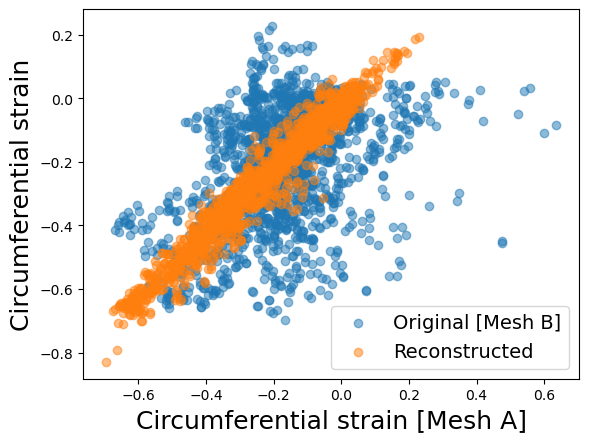

In [11]:
plt.scatter(srefC, stargetC, alpha = .5, label = 'Original [Mesh B]')
plt.scatter(srefC, scomputedC, alpha = .5, label = 'Reconstructed')
plt.ylabel('Circumferential strain', fontsize = 18)
plt.xlabel('Circumferential strain [Mesh A]', fontsize = 18)
plt.legend(fontsize = 14)
plt.savefig('Output/long2circ.pdf')

In [12]:
tgt_id,ref_id = ref_id, tgt_id
es_estimated = propagateDeformation.translateDeformation(ed[tgt_id], ed[ref_id], es[ref_id])
es_estimated += (ed[tgt_id].points[apexId] - es_estimated[apexId])
pGenerated2 = pyvista.PolyData(es_estimated, ed[tgt_id].faces)

srefL, srefC = computeStrainAnatomic( ed[tgt_id], es[tgt_id])
stargetL, stargetC = computeStrainAnatomic( ed[ref_id], es[ref_id])
scomputedL, scomputedC = computeStrainAnatomic( ed[tgt_id], pGenerated2)

pGenerated.cell_data['error_l'] = stargetL- scomputedL
pGenerated.cell_data['error_c'] = stargetC- scomputedC
pGenerated2.save('Output/exp2_es_tgt_estimated.vtk')
ed[tgt_id].save('Output/exp2_ed_tgt.vtk')
es[tgt_id].save('Output/exp2_es_tgt_real.vtk')
ed[ref_id].save('Output/exp2_ed_ref.vtk')
es[ref_id].save('Output/exp2_es_ref.vtk')
print('L strain MAE', np.mean(np.abs(stargetL - srefL)), np.mean(np.abs(stargetL - scomputedL)))
print('C strain MAE', np.mean(np.abs(stargetC - srefC)), np.mean(np.abs(stargetC - scomputedC)))


/home/gbernardino/miniconda3/lib/python3.9/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:144: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',
/home/gbernardino/rvmep/rvmep/anatomicalDirections.py:64: RuntimeWarning: invalid value encountered in divide
  vLongitudinal = vLongitudinal / np.linalg.norm(vLongitudinal, axis = 1).reshape((-1, 1))


L strain MAE 0.14221428440195702 0.04520199684099556
C strain MAE 0.13505688027360543 0.0401341328618728


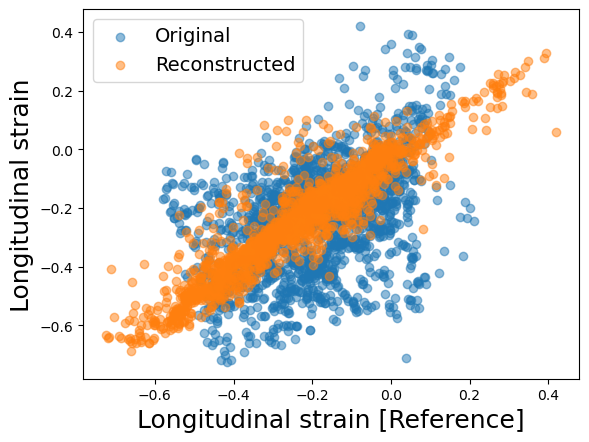

In [13]:
plt.scatter(srefL, stargetL, alpha = .5, label = 'Original')
plt.scatter(stargetL, scomputedL, alpha = .5, label = 'Reconstructed')
plt.xlabel('Longitudinal strain ', fontsize = 18)
plt.ylabel('Longitudinal strain', fontsize = 18)
plt.xlabel('Longitudinal strain [Reference]', fontsize = 18)
plt.legend(fontsize = 14)
plt.savefig('Output/circ2long.pdf')

## Mean experiment

In [37]:
ed_mean = np.mean([m.points for m in ed], axis = 0)
es_mean_procrustres = np.mean([m.points for m in es], axis = 0)
mean_displacement =  es_mean_procrustres - ed_mean
ed_mean_pyvista = pyvista.PolyData(ed_mean, faces = sampleMesh.faces )

In [38]:
def log_m(s):
    return np.array(
        [scipy.linalg.logm(si@si.T)/2 for si in s]
    )
def exp_m(s):
    return np.array(
        [scipy.linalg.expm(si) for si in s]
    )

def lie_mean(S):
    S_log = [log_m(s) for s in S ]
    return exp_m(np.mean(S_log, axis = 0))

In [9]:
scipy.linalg.logm
dihedral_diff_mean = np.mean(np.array(dihedralAngles_ed) - np.array(dihedralAngles_es), axis = 0)
S_anatomic_mean = np.mean(np.array(S_anatomic), axis = 0)
S_anatomic_mean = lie_mean(np.array(S_anatomic))

In [39]:
def reconstruct(ed_mean_pyvista):
    apexId, pointsTricuspid, pointsPulmonary = tools.getTomtecApexValvePointsRV()
    valvePoints = np.concatenate([pointsTricuspid, pointsPulmonary])
    edges = edgeStructures.getEdges(ed_mean_pyvista)
    triangles= ed_mean_pyvista.faces.reshape((-1, 4))[:, 1:]

    vLongitudinal, vCirc = anatomicalDirections.computeAnatomicalDirectionsHeatEquation(ed_mean_pyvista, apexId, valvePoints, True)
    systemOfCoordinatesTarget= np.stack([vLongitudinal, vCirc],axis = 1)

    dihedralsRef = meshReconstruction.computeDihedralAngles( ed_mean_pyvista.points,  ed_mean_pyvista.cell_normals, edges)

    pointsRef =  ed_mean_pyvista.points[triangles]
    dihedrals_transformed = dihedralsRef + dihedral_diff_mean
    coordinatesAnatomic = np.einsum('nij, nkj->nik', pointsRef, systemOfCoordinatesTarget)
    coordinatesAnatomic_transformed =np.einsum('nij, nkj->nki', S_anatomic_mean, coordinatesAnatomic)
    triangleCoordinates3D = propagateDeformation.getCoordinatesTriangle(ed_mean_pyvista, coordinatesAnatomic_transformed)
    es_nonlinear = deformMesh.deformMeshOptimisation(ed_mean_pyvista, triangleCoordinates3D, dihedrals_transformed)
    es_nonlinear += (ed_mean_pyvista.points[apexId] - es_nonlinear[apexId])
    return es_nonlinear

In [26]:
es_reconstructed_non_linear = []
for i,e in tqdm.tqdm(enumerate(ed)):
    es_reconstructed_non_linear.append(reconstruct(e))
    name = names[i]
    pyvista.PolyData(es_reconstructed_non_linear[-1], faces =ed[0].faces).save(f'Output/deformed_mean/{name}_deformed.vtk')


1it [00:44, 44.99s/it]/home/gbernardino/rvmep/rvmep/anatomicalDirections.py:64: RuntimeWarning: invalid value encountered in divide
  vLongitudinal = vLongitudinal / np.linalg.norm(vLongitudinal, axis = 1).reshape((-1, 1))
14it [18:18, 78.46s/it]


In [40]:
es_reconstructed_non_linear = []
for i,e in tqdm.tqdm(enumerate(ed)):
    name = names[i]
    es_reconstructed_non_linear.append(pyvista.PolyData(f'Output/deformed_mean/{name}_deformed.vtk').points)


14it [00:00, 537.15it/s]


In [54]:
def dist_procrustes(A,B, alignment = False):
    if alignment:
        A = A - np.mean(A, axis = 0)
        B = B - np.mean(B, axis = 0)

        R, _ = scipy.linalg.orthogonal_procrustes(A, B)
        A = A@R
    return np.mean(np.linalg.norm(A  - B, axis = 1))

In [55]:
import sklearn.cross_decomposition
import sklearn.model_selection

pls = sklearn.cross_decomposition.PLSRegression(n_components=1)
es_linear_pls =sklearn.model_selection.cross_val_predict(pls, [e.points.flatten() for e in ed], [e.points.flatten() for e in es]).reshape((len(es), -1, 3))

error_linear = []
error_pls = []
error_nonlinear = []
for i,m in enumerate([e.points for e in es]):
    error_nonlinear.append(
        dist_procrustes(es_reconstructed_non_linear[i], m)
    )
    error_linear.append(
        dist_procrustes(ed[i].points + mean_displacement, m)
    )
    error_pls.append(
        dist_procrustes(es_linear_pls[i], m )
    )



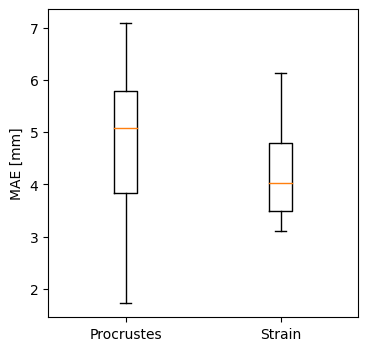

In [56]:
plt.figure(figsize = (4,4))
plt.boxplot([error_linear, error_nonlinear], labels = ['Procrustes', 'Strain']);
plt.ylabel("MAE [mm]")
plt.savefig('Output/reconstruction_eror.pdf')

In [152]:
es_mean_pyvista = pyvista.PolyData(es_mean_procrustres, faces = pGenerated.faces )
es_nonlinear_mean_pyvista = pyvista.PolyData(es_nonlinear, faces = pGenerated.faces )

ed_mean_pyvista.save('Output/ed_mean.vtk')
es_mean_pyvista.save('Output/es_mean.vtk')
es_nonlinear_mean_pyvista.save('Output/es_mean_nonlinear.vtk')

In [153]:
l,c = computeStrainAnatomic(ed_mean_pyvista, es_mean_pyvista)
print('GLC procrustes', np.mean(c))

l,c = computeStrainAnatomic(ed_mean_pyvista, es_nonlinear_mean_pyvista)
print('GLSCnonlinear', np.mean(c))

GLC procrustes -0.16984070232317255
GLSCnonlinear -0.1829564577813542


In [154]:
print('GLC mean', np.mean(glc))
gls

GLC mean -0.15613054726625514


[-0.15717380801082037,
 -0.18503166244014432,
 -0.19539848567586465,
 -0.1733517727816056,
 -0.2279865925306585,
 -0.1867540943741794,
 -0.16116080087484191,
 -0.17466009038364344,
 -0.15866267862329422,
 -0.20780047106241045,
 -0.19926532241254952,
 -0.18142422822559853,
 -0.19347002907789465,
 -0.20183669842785384]